In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# Description:
#   Exercise11 notebook.
#
# Copyright (C) 2018 Tapio Honka, Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from utils import findNeighbours, kpsObjToArray, plotMatches, camcalibDLT, vgg_X_fromxP_lin, vgg_P_from_F

# CS-E4850 Computer Vision Exercise Round 11

For these exercises you will need a python environment with necessary packages installed. For installation, see the README in the main page of this assignments repository.

The problems should be solved before the exercise session and solutions returned via the MyCourses page. Upload only ONE file for the programming tasks, i.e. this notebook filled with your implementations and anything else that is asked or needed.
Note that (1) you are not supposed to change anything in the utils.py and (2) you should be sure that everything that that you need to implement should work with the pictures specified by the assignments of this exercise round.

## Exercise 1 - Two-view structure from motion

In  this  exercise  you  will  estimate  the  fundamental  matrix  for  a  pair  of  uncalibrated images  and  recover  a  pair  of  camera  projection  matrices  that  are  compatible  with  the estimated  fundamental  matrix.  Thereafter,  triangulation  of  point  correspondences  using the  aforementioned  projection  matrices  gives  a  projective  reconstruction  of  the  scene, which  is  visualized  in  the  cell.

Proceed  as  follows  (__do  the  tasks  and  answer  the  questions 1-3__):

a) Check the cells below and try to run them.<br>

b) The  first  part  of  the  exercise  visualizes  the  inlier  correspondences  for  the  fundamental
matrix. __Q1:__ Explain  why  all  inliers  may  not  be  correct  correspondences. (Hint: Vary the number of plotted inliers to see the established matches better.)

c) The  second  part  of  the  code  calibrates  the  cameras  using  known  dimensions  of  the shelf  and  visualizes  a  wireframe  model  of  the  shelf  projected  onto  the  images.

d) The  third  part  triangulates  and  visualizes  a  projective  reconstruction  of  the  wire-frame  model.  __Q2:__ Give  an  explanation  why  the  model  looks  distorted  but  is  anyway correct.  (Hint: See  discussion  in  slides  of  Lecture  10.)

e) In  the  fourth  part  you  should  project  the  distorted  wireframe  model  onto  the  two images  and  check  that  it  matches  the  outlines  of  the  book  shelf.

f) __Q3:__ Describe  what  kind  of  information  could  be  used  to  upgrade  the  projective  reconstruction  to  a  similarity  reconstruction,  where  angles  and  ratios  of  lengths  are  the same  as  in  the  real  one,  without  knowing  the  dimensions  of  the  book  shelf.  (Hint: See  lecture  slides.)

#### Part 1 - Data loading, SIFT computations, matching, fundamental matrix estimation, and inlier visualization.

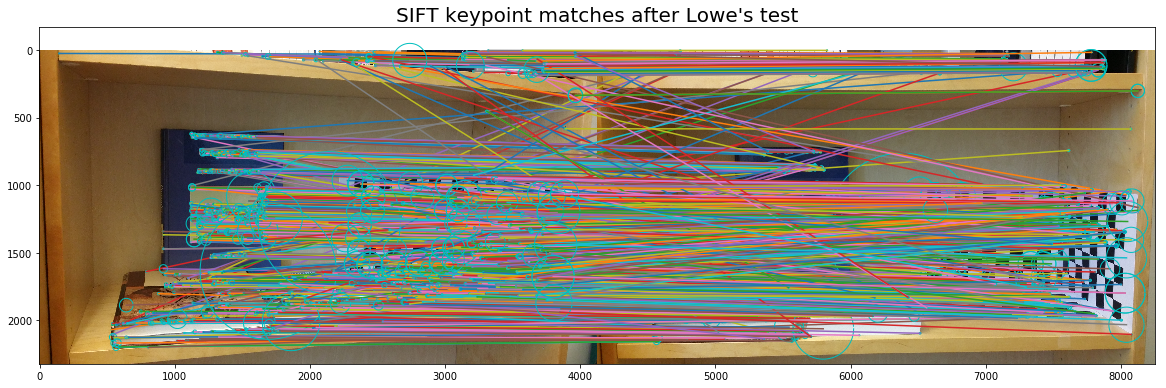

In [2]:
# Load the images (two views of the same scene)
im1 = imread('im1.jpg')
im2 = imread('im2.jpg')

# Initiate SIFT detector
#sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.06)
#keypoints1, desc1 = sift.detectAndCompute(im1, None)
#keypoints2, desc2 = sift.detectAndCompute(im2, None)

# Convert from OpenCV object to a numpy array
#kps1 = kpsObjToArray(keypoints1)
#kps2 = kpsObjToArray(keypoints2)

# We use precomputed features here
data1 = np.load('siftkpsdescrs_exercise1_im1.npy', encoding='latin1')
data2 = np.load('siftkpsdescrs_exercise1_im2.npy', encoding='latin1')
kps1 = data1.item().get('keypoints')
desc1 = data1.item().get('descriptors')
kps2 = data2.item().get('keypoints')
desc2 = data2.item().get('descriptors')

# Find the top two neighbours as well as their distances
ind, dist = findNeighbours(desc1, desc2, 2)

# Accept neighbours if their second best match is sufficiently far off (Lowe's ratio test)
nnThreshold = 0.8
ratio2 = np.divide(dist[:,0], dist[:,1])
ok = ratio2 <= nnThreshold ** 2

# Construct a list of filtered matches
matches_2nn = np.vstack((np.nonzero(ok), ind[ok, 0]))
matches_2nn = matches_2nn.T

# Display the corresponding matches (all here, feel free to change)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
plotMatches(ax, im1, im2, kps1, kps2, matches_2nn) # Plot every 10th
ax.set_title("SIFT keypoint matches after Lowe's test", fontsize=20)
plt.show()

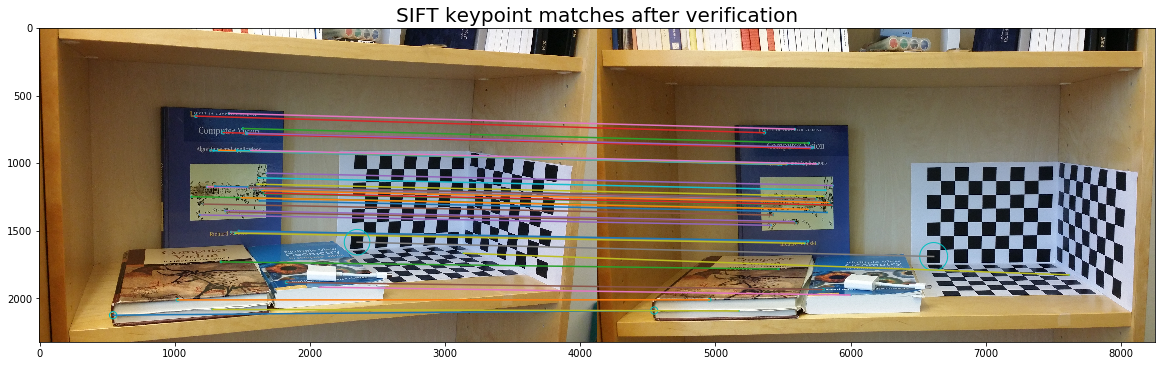

In [3]:
# Collect matching pairs and make homogenous
x1 = kps1[matches_2nn[:,0],:2]
x2 = kps2[matches_2nn[:,1],:2]
x1 = np.hstack((x1, np.ones((matches_2nn.shape[0],1))))
x2 = np.hstack((x2, np.ones((matches_2nn.shape[0],1))))

# Estimate F and retrieve inliers
F, mask = cv2.findFundamentalMat(x1, x2, method=cv2.FM_RANSAC)

# Display the corresponding matches (every 20th, feel free to change)
matches_2nn_masked = matches_2nn[mask.squeeze()==1,:]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
plotMatches(ax, im1, im2, kps1, kps2, matches_2nn_masked[::20,:]) # Plot every 20th
ax.set_title("SIFT keypoint matches after verification", fontsize=20)
plt.show()

In [4]:
# Calculate camera matrices based on F (you need these later)
P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P2 = vgg_P_from_F(F)

#### Part 2 - Given the known dimensions of the bookshelf calibrate the cameras.

In [5]:
# Give labels for the corners of the shelf
labels = ['a','b','c','d','e','f','g','h']

# Load image coordinates for the corners
x1 = loadmat('cornercoordinates.mat')['x1']
x2 = loadmat('cornercoordinates.mat')['x2']
y1 = loadmat('cornercoordinates.mat')['y1']
y2 = loadmat('cornercoordinates.mat')['y2']

# Define the 3D coordinates of the corners based on the known dimensions
ABCDEFGH_w = np.array([[758, 0, -295],
                    [0, 0, -295],
                    [758, 360, -295],
                    [0, 360, -295],
                    [758, 0 ,0],
                    [0, 0, 0],
                    [758, 360, 0],
                    [0, 360, 0]])

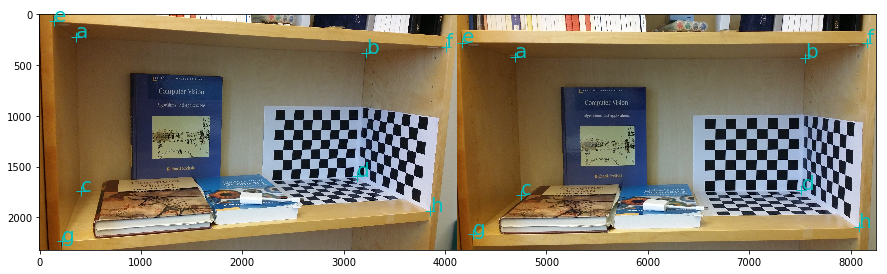

In [6]:
# Visualize the corners in the images
plt.figure(1, figsize=(15,15))
plt.imshow(np.hstack((im1, im2)))
plt.plot(x1, y1, 'c+', markersize=10)
plt.plot(x2 + im1.shape[1], y2, 'c+', markersize=10)

for i in range(np.size(x1)):
    plt.annotate(labels[i], (x1[i], y1[i]), color='c', fontsize=20)
    plt.annotate(labels[i], (x2[i]+im1.shape[1], y2[i]), color='c', fontsize=20)

In [7]:
# Calibrate the cameras from 3D <-> 2D correspondences
P1t = camcalibDLT(np.hstack((ABCDEFGH_w, np.ones((8,1)))),
                  np.hstack((x1, y1, np.ones((8,1)))))
P2t = camcalibDLT(np.hstack((ABCDEFGH_w, np.ones((8,1)))),
np.hstack((x2, y2, np.ones((8,1)))))

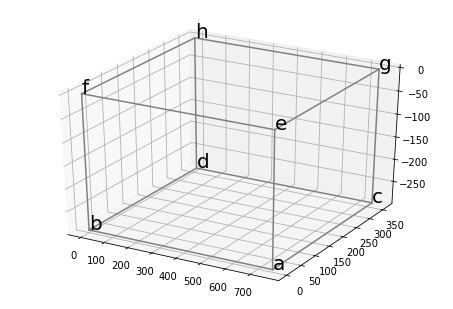

In [8]:
# Visualize a 3D sketch of the shelf
edges = np.array([[0,1], [0,2], [2,3], [1,3], [0,4], [4,5], [1,5],
               [4,6], [2,6], [3,7], [6,7], [5,7]]).T
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(2)
ax = Axes3D(fig)
for i in range(edges.shape[1]):
    ax.plot3D(ABCDEFGH_w[edges[:, i], 0], ABCDEFGH_w[edges[:, i], 1], ABCDEFGH_w[edges[:, i], 2], 'gray')
for i in range(8):
    ax.text(ABCDEFGH_w[i][0], ABCDEFGH_w[i][1], ABCDEFGH_w[i][2], labels[i], fontsize=20)

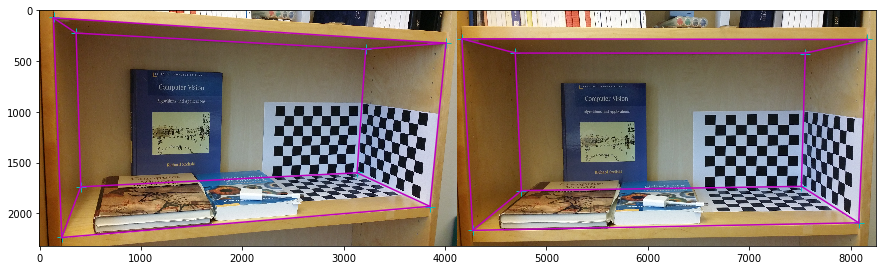

In [9]:
# Project the 3D corners of the wire-frame model to images
corners1 = np.dot(P1t, np.vstack((ABCDEFGH_w.T, np.ones(8))))
corners2 = np.dot(P2t, np.vstack((ABCDEFGH_w.T, np.ones(8))))
cx1 = (corners1[0,:] / corners1[2,:]).T
cy1 = (corners1[1,:] / corners1[2,:]).T
cx2 = (corners2[0,:] / corners2[2,:]).T
cy2 = (corners2[1,:] / corners2[2,:]).T

# Illustrate the edges of the shelf that connect its corners
plt.figure(1, figsize=(15,15))
plt.imshow(np.hstack((im1, im2)))
plt.plot(x1, y1, 'c+', markersize=10)
plt.plot(x2 + im1.shape[1], y2, 'c+', markersize=10)
for i in range(edges.shape[1]):
    plt.plot(cx1[edges[:,i]], cy1[edges[:,i]], 'm-')
    plt.plot(cx2[edges[:,i]]+im1.shape[1], cy2[edges[:,i]], 'm-')

#### Part 3 - Triangulate and visualize a projective reconstruction of the wire-frame model.

In [10]:
# Compute a projective reconstruction of the shelf
# That is, triangulate the corner correspondences using the camera projection
# matrices (P1 and P2) which were recovered from the fundamental matrix!

Xcorners = np.zeros((4,8))
for i in range(8):
    # the following function is from http://www.robots.ox.ac.uk/~vgg/hzbook/code/
    imsize = np.array([[im1.shape[1], im2.shape[1]],[im1.shape[0], im2.shape[0]]])
    P = [P1, P2]
    u = np.array([[x1[i], x2[i]],[y1[i], y2[i]]])
    Xcorners[:,i] = vgg_X_fromxP_lin(u, P, imsize) 
Xc = Xcorners[0:3,:] / Xcorners[[3,3,3], :]


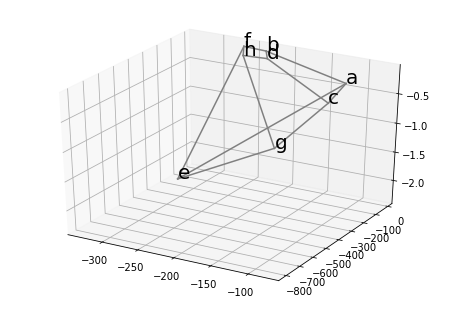

In [11]:
# Visualize the projection reconstruction
# Notice that the shape is not a rectangular cuboid
# (there is a projective distortion)
fig = plt.figure(3)
ax = Axes3D(fig)
for i in range(edges.shape[1]):
    ax.plot3D(Xc[0, edges[:, i]], Xc[1, edges[:, i]], Xc[2, edges[:, i]], 'gray')
for i in range(8):
    ax.text(Xc[0][i], Xc[1][i], Xc[2][i], labels[i], fontsize=20)

#### Part 4 - Project the distorted wire-frame model onto the two images.

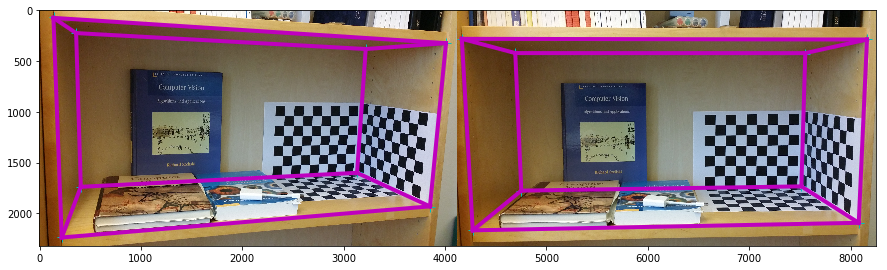

In [13]:
# Your task is to project the cuboid with corners 'Xc' to images 1 and 2.
# Use camera projection matrices P1 and P2.
# Visualize the results using cyan color.
# The resulting lines should be relatively close to the magenta lines which are alerady plotted.

##-your-code-starts-here-##




##-your-code-ends-here-##

plt.figure(1, figsize=(15,15))
plt.imshow(np.hstack((im1, im2)))

# magenta lines
plt.plot(x1, y1, 'c+', markersize=10)
plt.plot(x2 + im1.shape[1], y2, 'c+', markersize=10)
for i in range(edges.shape[1]):
    plt.plot(cx1[edges[:,i]], cy1[edges[:,i]], 'm-', lineWidth=4)
    plt.plot(cx2[edges[:,i]]+im1.shape[1], cy2[edges[:,i]], 'm-', lineWidth=4)
    
# plot your projected cyan lines here ...
